In [1]:
from scripts import support, metrics, vectorization as v, aggregation
from scripts.kuroda import kuroda
from scripts.insd import insd
from scripts.nras import nras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
%matplotlib inline

In [2]:
#CODES


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "NAICS Codes", skiprows=4)
df = df.iloc[:-6,:-1]
df = df.dropna(axis=0, how = 'all')
df = df.fillna(0)

codes = np.array(df)

In [3]:
#DET 2007


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2007")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2007 = np.array(df)
DET_2007 = np.where(DET_2007=='...', 0, DET_2007)
dt_2007 = v.tovector(DET_2007).astype(float)
# np.shape(DET_2007)

In [4]:
#DET 2012


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2012")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2012 = np.array(df)
DET_2012 = np.where(DET_2012=='...', 0, DET_2012)
dt_2012 = v.tovector(DET_2012).astype(float)


#Зануляем элементы, в которых меняется знак
det_2007 = dt_2007
det_2012 = dt_2012
det_2007[dt_2007 * dt_2012 < 0] = 0
det_2012[dt_2007 * dt_2012 < 0] = 0
DET_2012[DET_2007 * DET_2012 < 0] = 0


#Считаем итоги по строкам и столбцам
rows_sums_2012 = np.sum(DET_2012, axis=1)
columns_sums_2012 = np.sum(DET_2012, axis=0)
totals_2012 = np.concatenate((rows_sums_2012, columns_sums_2012)).astype(float)[np.newaxis].T
# DET_2012

In [5]:
#SUM 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2007")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2007 = np.array(df)
SUM_2007 = np.where(SUM_2007=='...', 0, SUM_2007)

SUM_2007[[72, 71]] = SUM_2007[[71, 72]]
sum_2007 = v.tovector(SUM_2007).astype(float)
# np.shape(SUM_2007)

In [6]:
#SUM 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2012")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2012 = np.array(df)
SUM_2012 = np.where(SUM_2012=='...', 0, SUM_2012)

SUM_2012[[72, 71]] = SUM_2012[[71, 72]]
sum_2012 = v.tovector(SUM_2012).astype(float)
# SUM_2012

In [7]:
#SECT 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2007")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2007 = np.array(df)
SECT_2007 = np.where(SECT_2007=='...', 0, SECT_2007)
sect_2007 = v.tovector(SECT_2007).astype(float)
# SECT_2007

In [8]:
#SECT 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2012")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2012 = np.array(df)
SECT_2012 = np.where(SECT_2012=='...', 0, SECT_2012)
sect_2012 = v.tovector(SECT_2012).astype(float)
# SECT_2012

In [9]:
#parsing aggregation codes


sect_rows, sect_columns, sum_rows, sum_columns = aggregation.parse_agg(codes)

In [10]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SUM (73,71)

left_sum = aggregation.make_keym(405, 73, sum_rows)
right_sum = aggregation.make_keym(405, 71, sum_columns)

g_to_sum = csr_matrix(aggregation.keys_to_g(left_sum, right_sum))

In [11]:
aggregation.keys_to_g(left_sum, right_sum)

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [12]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SECT (17,15)

left_sect = aggregation.make_keym(405, 17, sect_rows)
right_sect = aggregation.make_keym(405, 15, sect_columns)

g_to_sect = csr_matrix(aggregation.keys_to_g(left_sect, right_sect))

In [13]:
g_sum_w_totals = v.addrows((405,405), g_to_sum, sparsed=True)
g_sum_w_totals = v.addcolumns((405,405), g_sum_w_totals, sparsed=True)

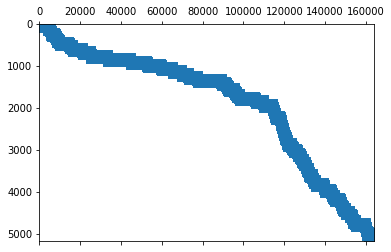

In [14]:
plt.spy(g_to_sum,aspect='auto')

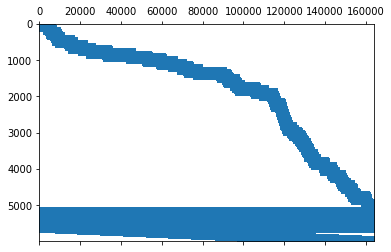

In [15]:
plt.spy(g_sum_w_totals,aspect='auto')

In [16]:
np.shape(totals_2012)

(810, 1)

In [17]:
true_sum_2012 = g_to_sum @ det_2012
sum_2012_with_totals = np.append(sum_2012, totals_2012, axis=0)
true_sum_2012_with_totals = np.append(true_sum_2012, totals_2012, axis=0)

In [25]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Метод: NRAS, точность 0.01, 100 иттераций



result_sum_to_det = np.round(nras.nras(g_to_sum, det_2007, sum_2012, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

1
N0 1483
PSISTAT 0.0338
RSQ 0.9684
MAPE 14.9574
SWAD 0.066
WAPE 23.2183


In [26]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: NRAS, точность 0.01, 100 иттераций


result_sum_to_det = np.round(nras.nras(g_to_sum, det_2007, true_sum_2012, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

1
N0 1481
PSISTAT 0.0338
RSQ 0.9684
MAPE 14.9614
SWAD 0.066
WAPE 23.2184


In [19]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: NRAS, точность 0.01, 100 иттераций




result_sum_to_det = np.round(nras.nras(g_sum_w_totals, det_2007, sum_2012_with_totals, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

100
N0 1461
PSISTAT 0.0146
RSQ 0.9909
MAPE 9.9558
SWAD 0.0317
WAPE 13.0282


In [20]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012 + итоги по строкам и столбцам
#Метод: NRAS, точность 0.01, 100 иттераций




result_sum_to_det = np.round(nras.nras(g_sum_w_totals, det_2007, true_sum_2012_with_totals, 0.01, 100, sparsed=True))
metrics.get_values(result_sum_to_det, det_2012)

100
N0 1451
PSISTAT 0.0146
RSQ 0.9909
MAPE 9.9497
SWAD 0.0317
WAPE 13.0281


In [21]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_to_sum, det_2007, sum_2012, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [22]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_to_sum, det_2007, true_sum_2012, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [23]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_sum_w_totals, det_2007, sum_2012_with_totals, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [24]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012 + итоги по строкам и столбцам
#Метод: INSD



result_sum_to_det = np.round(insd.insd(g_sum_w_totals, det_2007, true_sum_2012_with_totals, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in insd
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\insd.py", line 69, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [25]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_to_sum, det_2007, sum_2012, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [26]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_to_sum, det_2007, true_sum_2012, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [27]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: таблица SUM_2012 + итоги по строкам и столбцам
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_sum_w_totals, det_2007, sum_2012_with_totals, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [28]:
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012 + итоги по строкам и столбцам
#Метод: Kuroda 1



result_sum_to_det = np.round(kuroda.kuroda(g_sum_w_totals, det_2007, true_sum_2012_with_totals, mtype=1, sparsed=True))
result_sum_to_det
# metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


ERROR:root:Traceback (most recent call last):
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in kuroda
    result = np.array([v.x for v in model.getVars()])
  File "D:\materials\lab\gitprjct\Disaggregation\scripts\kuroda.py", line 116, in <listcomp>
    result = np.array([v.x for v in model.getVars()])
  File "var.pxi", line 76, in gurobipy.Var.__getattr__
  File "var.pxi", line 142, in gurobipy.Var.getAttr
AttributeError: b"Unable to retrieve attribute 'x'"



-1

In [142]:
ttls = v.addrows((405,405))
ttls = v.addcolumns((405,405), ttls)

tst = kuroda.kuroda(ttls, det_2007, totals_2012, 1)
metrics.get_values(tst, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
N0 1521
PSISTAT 0.0427
RSQ 0.95
MAPE 13.6231
SWAD 0.1043
WAPE 26.693


In [151]:
ttls = v.addrows((405,405))
ttls = v.addcolumns((405,405), ttls)

tst = insd(ttls, det_2007, totals_2012)
metrics.get_values(tst, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
N0 2314
PSISTAT 0.0283
RSQ 0.9758
MAPE 12.4813
SWAD 0.0644
WAPE 20.5014


In [88]:
from scripts.insd import insd as insd_original
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: INSD2



result_sum_to_det = np.round(insd(aggregation.keys_to_g(left_sum, right_sum), det_2007, sum_2012, sparsed=False))
result_sum_to_det
metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
N0 1442
PSISTAT 0.0338
RSQ 0.9684
MAPE 14.9635
SWAD 0.066
WAPE 23.218


In [102]:
from scripts.insd import insd as insd_original
#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: INSD2


#_w_totals
result_sum_to_det = np.round(insd(g_to_sum, det_2007, true_sum_2012_with_totals, sparsed=True))
result_sum_to_det
metrics.get_values(result_sum_to_det, det_2012)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
N0 1445
PSISTAT 0.0338
RSQ 0.9684
MAPE 14.9675
SWAD 0.066
WAPE 23.2179


In [257]:
from scripts.kuroda import kuroda as kuroda_original


#Эксперимент: дезаггрегация таблицы DET_2012 из таблицы SUM_2012
#Бенчмарк: DET_2007
#Ограничения: агрегированная таблица DET_2012
#Метод: KURODA



result_sum_to_det = np.round(kuroda(g_to_sum, det_2007, sum_2012, sparsed=True, mtype=3))
result_sum_to_det
metrics = metrics.get_values(result_sum_to_det, det_2012, save=True)


Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


In [135]:
from scripts import support, metrics, vectorization as v, aggregation
def experiment(method_name, bench_matrix, origin_matrix, target_matrix, experiment_type, sparsed = True, save = True):
    """
    Получение результата эксперимента

    Parameters
    ----------
    method_name: string
        метод для получения новой матрицы
    bench_matrix: np.array или sparse матрица
        бенчмарк таблица
    origin_matrix: np.array или sparse матрица
        оригинальная таблица
    target_matrix: np.array или sparse матрица
        целевая таблица
    experiment_type: string
        агрегация\дезаггрегация\нет
    sparse: bool
        использовать sparse матрицу или np.array
    Returns
    -------
    a: float
        значение метрики
    """
    if experiment_type == 'дезаггрегация':
        if sparsed:
            g = g_to_sum
        else:
            g = aggregation.keys_to_g(left_sum, right_sum)
    
    # For Kuroda
    if len(method_name.split('_')) > 1:
        
        method, mtype = method_name.split('_')
        method = eval(method)
        results = np.round(method(g, eval(bench_matrix), eval(origin_matrix), mtype=int(mtype), sparsed=sparsed))
    else:
        method = eval(method_name)
        results = method(g, eval(bench_matrix), eval(origin_matrix), sparsed=sparsed)
    metrics_values = metrics.get_values(np.round(results), eval(target_matrix), save=True)
    
    # Save metrics' results
    if save:
        info = {'method':method_name, 'experiment_type':experiment_type, 'target_matrix':target_matrix, 
                'origin_matrix':origin_matrix, 'bench_matrix':bench_matrix}
        info = {**info,**metrics_values}

        res_table = pd.read_excel('results/results.xlsx')
        res_table = res_table.append([info])
        res_table.to_excel('results/results.xlsx', index=None,encoding='utf-8')

    return metrics_values 


In [37]:
experiment('nras', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', True)

1


{'MAPE': 14.9614,
 'N0': 1481,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2184}

In [38]:
experiment('insd', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 14.9675,
 'N0': 1445,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2179}

In [95]:
experiment('kuroda_3', 'det_2007', 'sum_2012', 'det_2012', 'дезаггрегация', sparsed = True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 15.0569,
 'N0': 1879,
 'PSISTAT': 0.0339,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2346}

In [139]:
experiment('kuroda_2', 'det_2007', 'sum_2012', 'det_2012', 'дезаггрегация', sparsed = True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 28.6641,
 'N0': 9221,
 'PSISTAT': 0.163,
 'RSQ': 0.905,
 'SWAD': 0.0869,
 'WAPE': 40.5225}

In [142]:
from scripts.kuroda import kuroda as kurodaoriginal
experiment('kurodaoriginal_2', 'det_2007', 'sum_2012', 'det_2012', 'дезаггрегация', sparsed = False, save=False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 14.9871,
 'N0': 1458,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2236}

In [141]:
experiment('kuroda_1', 'det_2007', 'sum_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 14.9823,
 'N0': 1447,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2231}